# Part 3 - Modeling!

### Load CSV of Friends Transcript

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import seaborn as sns

In [5]:
df = pd.read_csv('friends_transcripts_clean.csv')

In [6]:
df.drop(axis=1, columns=['Unnamed: 0', 'Line'], inplace=True)

In [7]:
df.head()

,Season,Episode,Title,Character,Clean_Lines
0,1,101,The One Where Monica Gets a New Roomate (The P...,Monica,There's nothing to tell! He's just some guy I...
1,1,101,The One Where Monica Gets a New Roomate (The P...,Joey,"C'mon, you're going out with the guy! There's..."
2,1,101,The One Where Monica Gets a New Roomate (The P...,Chandler,"All right Joey, be nice. So does he have a h..."
3,1,101,The One Where Monica Gets a New Roomate (The P...,Phoebe,"Wait, does he eat chalk?"
4,1,101,The One Where Monica Gets a New Roomate (The P...,Phoebe,"Just, 'cause, I don't want her to go through ..."


## Modeling

We will be training multiple models on our dataset and picking the best performing one. We will look at the following three models: Logistic Regression, Naive Bayes, and Random Forest.

We will train the models using a subset of data our called training set and validate with another subset called testing set. 

Our models will be trained using k-fold cross validation. Using this method we train our models multiple times using different set of training and test data. k-fold helps us to predict the performance of our models on unavailable data.

### Using Count Vectorizer

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [10]:
#Label Encode y
from sklearn.preprocessing import LabelEncoder

In [36]:
X = df.Clean_Lines
y = df.Character
# Setting training and testing data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=.2, random_state=1)

In [12]:
le = LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)
y_le = le.transform(y)

In [13]:
sw = stopwords.words("english")
add_words = ["now","oh","know","yeah","hey","okay","right"]
stp_wrds = sw+add_words

In [25]:
%%time
model = make_pipeline(CountVectorizer(stop_words='english',
                                      ngram_range=(1,3),
#                                       lowercase=True,
#                                       min_df=2
                                     ),
                      LogisticRegression(),
                      )
model.fit(X_train, y_train_le)
y_pred = model.predict(X_test)
print(accuracy_score(y_test_le, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.2988494247123562
Number of features: 219010
Wall time: 42 s


In [128]:
import os
import pickle

with open("model.pkl","wb") as pkl_file:
    pickle.dump(model,pkl_file)

In [129]:
with open("model.pkl","rb") as pkl_file:
    model2 = pickle.load(pkl_file)
    

In [26]:
%%time
model_name = model.__class__.__name__
number_of_folds = 5
entries = []

accuracies = cross_val_score(model, X, y_le, scoring='accuracy', cv=number_of_folds)
for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cross_validations_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
display(cross_validations_df)

,model_name,fold_idx,accuracy
0,Pipeline,0,0.265906
1,Pipeline,1,0.274210
2,Pipeline,2,0.271709
3,Pipeline,3,0.268161
4,Pipeline,4,0.268342


Wall time: 2min 51s


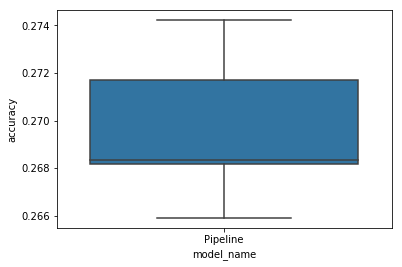

In [29]:
sns.boxplot(
    x='model_name',
    y='accuracy',
    data=cross_validations_df
);

We see that the Multinomial Naive Bayes model has a high variance. This means that the model was overfitting to the training data. Using cross validation helped us spot this shortcoming.

We also see that LogisticRegression performed the best in this case. Naive Bayes and Random Forest Classifier are generally considered to be better models. But there is no such thing as a 'better model' and we have to try out various models to find out what works best for a given dataset.

Now lets look at the accuracy of our models.

In [30]:
cross_validations_df.groupby('model_name').accuracy.mean()

model_name
Pipeline    0.269665
Name: accuracy, dtype: float64

The accuracy values are not the best but they are definitely better than flipping a coin. Accuracy for a coin flip is about 0.2 accuracy for 5 casts. We are getting better number from all our models with LogisticRegression performing the best at 0.5.

We will do further analysis on our winning LogisticRegression model by generating a confusion matrix.

Text(0.5,15,'Predicted')

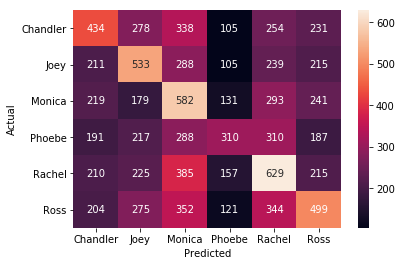

In [32]:
# visualizing confusion matrix
conf_mat = confusion_matrix(y_test_le, y_pred)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',    
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Because our model did not have high accuracy, we see that our predictions are all over the place. We see very high prediction number for Frasier because he has the most number of documents in the dataset.

Lets pick some incorrect classifications and try to find what caused them.

In [58]:
id_to_cast = {cast_id:name for cast_id, name in zip (set(y_le), le.classes_)}

In [59]:
cast_to_id = {name:cast_id for name, cast_id in zip(le.classes_, set(y_le))}

In [49]:
for predicted in set(y_le):
    count = 0
    for actual in set(y_le):
        if predicted != actual and conf_mat[actual, predicted] >= 2:        
            print(
                "'{}' predicted as '{}'".format(
                    le.classes_[actual],
                    le.classes_[predicted],
                )
            )
            print("-" * 10)
            print("\n".join(df.loc[indices_test[(y_test_le == actual) & (y_pred == predicted)]].head().Clean_Lines.tolist()))
            print("\n")

'Joey' predicted as 'Chandler'
----------
What're you talking about, everybody loves Joseph.
 Ill see you at 8:00.
 Whos Elaine?
Joseph's good, isn't he?
 Uuuh.. yes, they are my stuffed clams.


'Monica' predicted as 'Chandler'
----------
 Spend more time with the tie. That'll make a baby.
 No its not, its second.
 Yes!!
 Yes. 
 Now everybody knows the basic erogenous zones.  You got one, two three, four s more than three), five, six, and seven!


'Phoebe' predicted as 'Chandler'
----------
 Okay, you're on.
 Yes. Definitely! Yes! Let's live in an apartment that we both live in! .) 
 What happened?
 Fine! You go learn from your qualified instructor! But don't come crying to me when everyone's sick and tired of hearing you play Bad, Bad Leroy Brown!!
 Okay. .)


'Rachel' predicted as 'Chandler'
----------
 Okay. .) 
 Dont!! .)
I can't believe this is happening.
 Okay.
 No! It didnt! Thats what I want to talk to you about.  Now, just to brief you  I may cry, but they are not te

 Thank you. .) Hey-hey umm, uh, is there, is there any such thing as an annulment shower?




To understand the incorrect prediction one has to know the characters of the data well(This is where a domain expert would come into play in real life data science problems.) 
#### Insert analysis on the character

In [98]:
number_of_words = 5
for cast, cast_id in sorted(cast_to_id.items()):
    indices = np.argsort(model.steps[1][1].coef_[cast_id])
    feature_names = np.array(model.steps[0][1].get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:number_of_words]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:number_of_words]
    print("# '{}':".format(cast))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Chandler':
  . Top unigrams:
       . joe
       . eddie
       . janice
       . babe
       . tulsa
  . Top bigrams:
       . oh come
       . chandler bing
       . big guy
       . hello children
       . oh yes
# 'Joey':
  . Top unigrams:
       . comin
       . dude
       . agent
       . doin
       . kate
  . Top bigrams:
       . hi joey
       . okay phoebe
       . joey tribbiani
       . pheebs sorry
       . know yeah
# 'Monica':
  . Top unigrams:
       . sweetie
       . pete
       . plates
       . lasagnas
       . nana
  . Top bigrams:
       . monica geller
       . god emma
       . did like
       . hey good
       . hell yeah
# 'Phoebe':
  . Top unigrams:
       . frank
       . mike
       . yay
       . ursula
       . massage
  . Top bigrams:
       . uh huh
       . uh hmm
       . uh joe
       . chandler monica
       . oh guy
# 'Rachel':
  . Top unigrams:
       . joshua
       . barry
       . ugh
       . joanna
       . tag
  . Top bigrams:
       .

In [99]:
from wordcloud import WordCloud

In [100]:
wc = WordCloud(mode='RGBA',background_color='white',colormap='Spectral',random_state=2)

In [108]:
rachel_dialogue = str(0)
for line in df.Clean_Lines[df.Character=='Rachel']:
    rachel_dialogue+=line

In [111]:
wc.generate_from_text(rachel_dialogue)

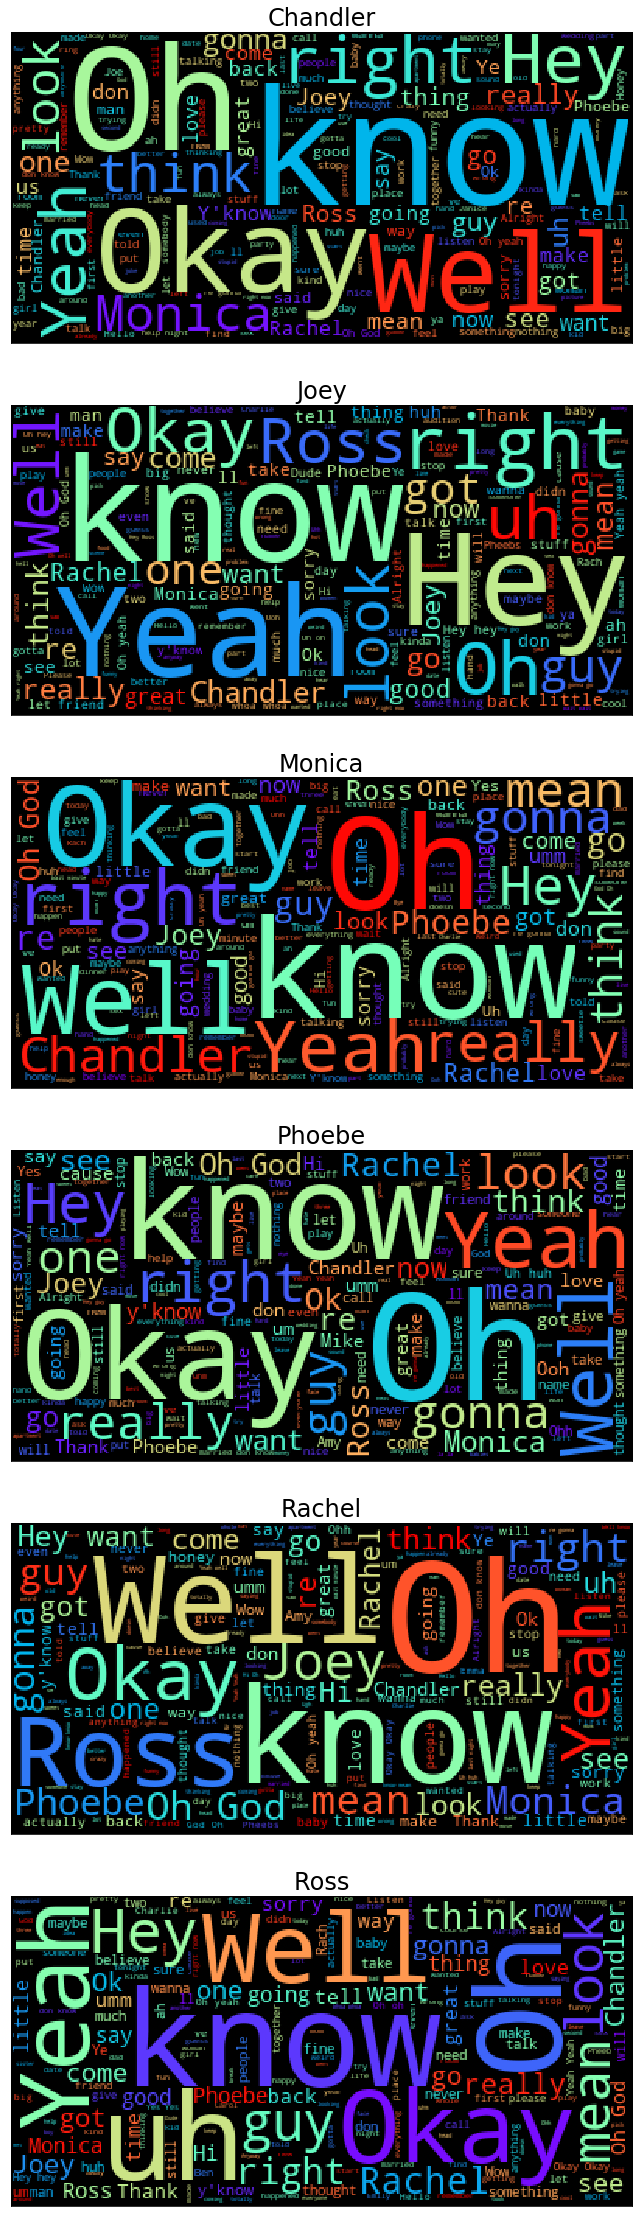

In [118]:
#Make a Word Cloud for each Character
wc_gen = {}
wc = WordCloud(mode='RGBA',background_color='black',colormap='rainbow',random_state=2)

fig, ax = plt.subplots(nrows=6,figsize=(12,40))

for cast, cast_id in sorted(cast_to_id.items()):
    cast_dialogue = str(0)
    for line in df.Clean_Lines[df.Character == cast]:
        cast_dialogue+=line
    wc_gen[cast_id] = wc.generate_from_text(cast_dialogue)
    ax[cast_id].imshow(wc_gen[cast_id])
    ax[cast_id].set_title(cast,fontsize=24)
    ax[cast_id].set_xticks([])
    ax[cast_id].set_yticks([])
    
plt.show()

## Predict on new data

### Once we have determined which classification model works best with our data, we can now set that as our model and use it to predict

In [71]:
# function printing document and assigned class
def my_classifier(my_list):
    my_pred = model.predict(my_list)
    preds = [le.classes_[pred] for pred in my_pred]
    return list(zip(my_list,preds))

# print function
def my_printer(my):
    for i in range(len(my)):
        print('Word/Phrase: ')
        print(my[i][0])
        print('Assigned Character: ')
        print(my[i][1])
        print()

In [69]:
# single words
my_list = ['men','women','tree','shark','computer','internet','star',
               'quantum','magnet','english','swimming','horse','rain']
my = my_classifier(my_list)

In [67]:
my_printer(my)

Word/Phrase: 
men
Assigned Character: 
Rachel

Word/Phrase: 
women
Assigned Character: 
Joey

Word/Phrase: 
tree
Assigned Character: 
Phoebe

Word/Phrase: 
shark
Assigned Character: 
Monica

Word/Phrase: 
computer
Assigned Character: 
Chandler

Word/Phrase: 
internet
Assigned Character: 
Chandler

Word/Phrase: 
star
Assigned Character: 
Monica

Word/Phrase: 
quantum
Assigned Character: 
Monica

Word/Phrase: 
magnet
Assigned Character: 
Monica

Word/Phrase: 
english
Assigned Character: 
Ross

Word/Phrase: 
swimming
Assigned Character: 
Chandler

Word/Phrase: 
horse
Assigned Character: 
Monica

Word/Phrase: 
rain
Assigned Character: 
Ross



#### Try with a recognizable line from each character

In [72]:
# Joey - How you doin 
joey = ['How you doin?']
my = my_classifier(joey)
my_printer(my)

Word/Phrase: 
How you doin?
Assigned Character: 
Joey



In [73]:
# Ross - We were on a break! 
ross = ['We were on a break!']
my = my_classifier(ross)
my_printer(my)

Word/Phrase: 
We were on a break!
Assigned Character: 
Ross



In [119]:
# Rachel - How you doin 
rachel = ['Ralph lauren, bloomingdales, fashion']
my = my_classifier(rachel)
my_printer(my)

Word/Phrase: 
Ralph lauren, bloomingdales, fashion
Assigned Character: 
Rachel



In [81]:
# Monica - How you doin 
monica = ['I love having things organized and clean']
my = my_classifier(monica)
my_printer(my)

Word/Phrase: 
I love having things organized and clean
Assigned Character: 
Monica



In [79]:
# Chandler - How you doin 
chandler = ['My father was a headliner at a gay nightclub']
my = my_classifier(chandler)
my_printer(my)

Word/Phrase: 
My father was a headliner at a gay nightclub
Assigned Character: 
Chandler



In [78]:
# Phoebe - My psychic told me I'm going to die 
phoebe = ['My psychic told me Im going to die']
my = my_classifier(phoebe)
my_printer(my)

Word/Phrase: 
My psychic told me Im going to die
Assigned Character: 
Phoebe

